<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation-with-Deep-Learning/blob/master/data/notebooks/Hyperparameter_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Imports

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from scipy.ndimage.filters import gaussian_filter1d
from tensorflow.keras import layers, models, backend, utils, optimizers, regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Dataset Setup

In [2]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

class_train_indices = np.argwhere(train_labels == 0)
train_images = train_images[class_train_indices[:,0]]
train_labels = train_labels[class_train_indices[:,0]]
class_test_indices = np.argwhere(test_labels == 0)
test_images = test_images[class_test_indices[:,0]]
test_labels = test_labels[class_test_indices[:,0]]


output_count = 12
index_offset = 20

train_yuv  = tf.image.rgb_to_yuv(train_images)
train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
train_uv = train_yuv[:,:,:,1:]

test_yuv = tf.image.rgb_to_yuv(test_images)
test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
test_uv = test_yuv[:,:,:,1:]

170500096/170498071 [==============================] - 11s 0us/step


# Define Model

In [0]:
# Place the structure of your model within this function
# Modify the function to accept the particular hyper-parameter you want to test, so it can be passed to the model
def create_model(param):
  # Place your model in a sequential object, so it can be remade
  model = models.Sequential()
  model.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(32, 32, 1)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(16, (3, 3), activation='tanh', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  opt = optimizers.Adam(lr=param)
  model.compile(optimizer=opt, loss='mse')
  return model

# Define and Train on Parameters

In [8]:
results = []
val_results = []
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, rotation_range=60)
train_iterator = datagen.flow(train_y, train_uv, batch_size=128)

# Add hyper-parameter values as a list
parameters = [0.00001, 0.0001, 0.001]

# Define the name of the hyper-parameter to be tested
parameter_name = "Learning Rate"

# Iterate through parameters, and train on each
for parameter in parameters:
  start = time.time()
  model = create_model(parameter)
  history = model.fit(train_iterator, steps_per_epoch=int(train_yuv.shape[0]/128), epochs=20, validation_data=(test_y, test_uv), validation_steps=int(test_yuv.shape[0]/128), verbose=1)
  results.append(history.history["loss"])
  val_results.append(history.history["val_loss"])
  print("Total time taken:", time.time()-start)

Epoch 1/20
39/39 [==============================] - 1s 32ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 2/20
39/39 [==============================] - 1s 30ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 3/20
39/39 [==============================] - 1s 32ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 4/20
39/39 [==============================] - 1s 30ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 5/20
39/39 [==============================] - 1s 30ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 6/20
39/39 [==============================] - 1s 29ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 7/20
39/39 [==============================] - 1s 30ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 8/20
39/39 [==============================] - 1s 30ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 9/20
39/39 [==============================] - 1s 30ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 10/20
39/39 [==============================] - 1s 30ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 11/

# Training & Testing Results

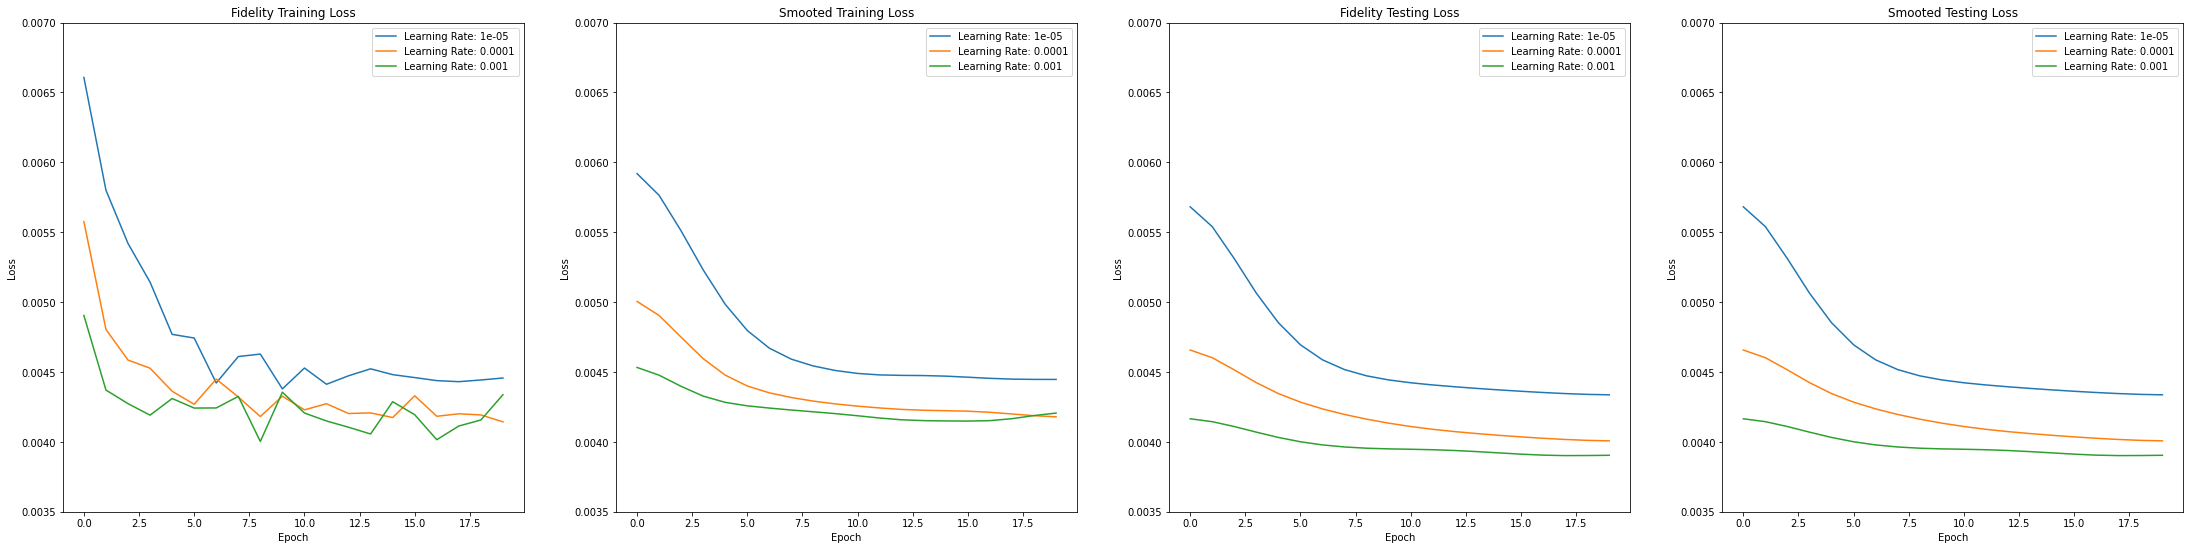

In [21]:
# Change the code for these graphs as necessary to best demonstrate the results

fig = plt.figure(figsize=(38, 9))

ax = fig.add_subplot(1,4,1)
ax.set_ylim([0.0035,0.007]) # Set y axis range if needed
for i in range(len(parameters)):
  plt.plot(results[i], label=parameter_name + ": " + str(parameters[i]))
plt.title('Fidelity Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

ax = fig.add_subplot(1,4,2)
ax.set_ylim([0.0035,0.007]) # Set y axis range if needed
for i in range(len(parameters)):
  plt.plot(gaussian_filter1d(results[i], sigma=2), label=parameter_name + ": " + str(parameters[i]))
plt.title('Smooted Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

ax = fig.add_subplot(1,4,3)
ax.set_ylim([0.0035,0.007]) # Set y axis range if needed
for i in range(len(parameters)):
  plt.plot(gaussian_filter1d(val_results[i], sigma=2), label=parameter_name + ": " + str(parameters[i]))
plt.title('Fidelity Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

ax = fig.add_subplot(1,4,4)
ax.set_ylim([0.0035,0.007]) # Set y axis range if needed
for i in range(len(parameters)):
  plt.plot(gaussian_filter1d(val_results[i], sigma=2), label=parameter_name + ": " + str(parameters[i]))
plt.title('Smooted Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
